In [16]:
# 1. Environment Setup and Data Loading
# Loads all necessary libraries and tools

import requests
import zipfile
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
import joblib
import json

plt.style.use('default')
sns.set_palette("husl")

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [17]:
# 2. Download and Load the Dataset
# Downloads the CI/CD pipeline data from the Ruby on Rails project

print("Downloading Ruby on Rails CI/CD dataset...")
url = 'https://github.com/elbaum/CI-Datasets/raw/master/RailsCleanData.out.zip'
response = requests.get(url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    file_name = z.namelist()[0]
    column_names = [
        'Test Suite', 'Test Suite Start Time', 'Test Suite Duration',
        'Test Suite Runs', 'Test Suite Assertions', 'Test Suite Failures',
        'Test Suite Errors', 'Test Suite Skips', 'Build Number',
        'Build Pull Request', 'Commit Sha', 'Build State',
        'Build Start Time', 'Build Finish Time', 'Build Duration',
        'Job Id', 'Job Start Time', 'Job Allow Failure'
    ]
    df = pd.read_csv(z.open(file_name), sep=';', header=None, names=column_names)

print(f"Dataset loaded: {df.shape[0]:,} rows and {df.shape[1]} columns")
df.head()

Dataset loaded: 3,594,276 rows and 18 columns


,Test Suite,Test Suite Start Time,Test Suite Duration,Test Suite Runs,Test Suite Assertions,Test Suite Failures,Test Suite Errors,Test Suite Skips,Build Number,Build Pull Request,Commit Sha,Build State,Build Start Time,Build Finish Time,Build Duration,Job Id,Job Start Time,Job Allow Failure
0,railties/test/app_rails_loader_test.rb,2016-03-24 19:01:23.0,0.035011,16,20,0,0,0,33391,True,246c1248e5f5e38125898a72d21d4fe58e6182be,"passed,2016-03-24 19:01:23.0",2016-03-24 19:22:08.0,1245000.0,118308786,2016-03-24 18:42:35.0,False,NaN
1,railties/test/application/asset_debugging_test.rb,2016-03-24 19:01:23.0,17.408814,2,9,0,0,0,33391,True,246c1248e5f5e38125898a72d21d4fe58e6182be,"passed,2016-03-24 19:01:23.0",2016-03-24 19:22:08.0,1245000.0,118308786,2016-03-24 18:42:35.0,False,NaN
2,railties/test/backtrace_cleaner_test.rb,2016-03-24 19:01:40.0,162.113491,30,116,0,0,0,33391,True,246c1248e5f5e38125898a72d21d4fe58e6182be,"passed,2016-03-24 19:01:23.0",2016-03-24 19:22:08.0,1245000.0,118308786,2016-03-24 18:42:35.0,False,NaN
3,railties/test/code_statistics_calculator_test.rb,2016-03-24 19:04:22.0,41.402265,2,7,0,0,0,33391,True,246c1248e5f5e38125898a72d21d4fe58e6182be,"passed,2016-03-24 19:01:23.0",2016-03-24 19:22:08.0,1245000.0,118308786,2016-03-24 18:42:35.0,False,NaN
4,railties/test/engine_test.rb,2016-03-24 19:05:03.0,2.786692,1,6,0,0,0,33391,True,246c1248e5f5e38125898a72d21d4fe58e6182be,"passed,2016-03-24 19:01:23.0",2016-03-24 19:22:08.0,1245000.0,118308786,2016-03-24 18:42:35.0,False,NaN


In [18]:
# 3. Data Cleaning and Feature Engineering
# Cleans the data and creates new features for prediction

df.columns = df.columns.str.strip()
time_columns = ['Test Suite Start Time', 'Build Start Time', 'Build Finish Time']
for col in time_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

duration_upper_bound = df['Test Suite Duration'].quantile(0.99)
initial_size = len(df)
df = df[df['Test Suite Duration'] < duration_upper_bound]
print(f"Removed {initial_size - len(df):,} outliers (top 1% of durations)")

df['start_day_of_week'] = df['Test Suite Start Time'].dt.dayofweek
df['start_hour_of_day'] = df['Test Suite Start Time'].dt.hour
df['log_duration'] = np.log1p(df['Test Suite Duration'])

print("Feature engineering complete!")
print(f"Final dataset size: {len(df):,} rows")

Removed 35,943 outliers (top 1% of durations)
Feature engineering complete!
Final dataset size: 3,558,333 rows


Duration Statistics (in seconds):
count    3.558333e+06
mean     8.429412e+00
std      3.049998e+01
min      1.438390e-04
25%      5.468170e-02
50%      2.908430e-01
75%      1.632909e+00
max      2.926757e+02
Name: Test Suite Duration, dtype: float64


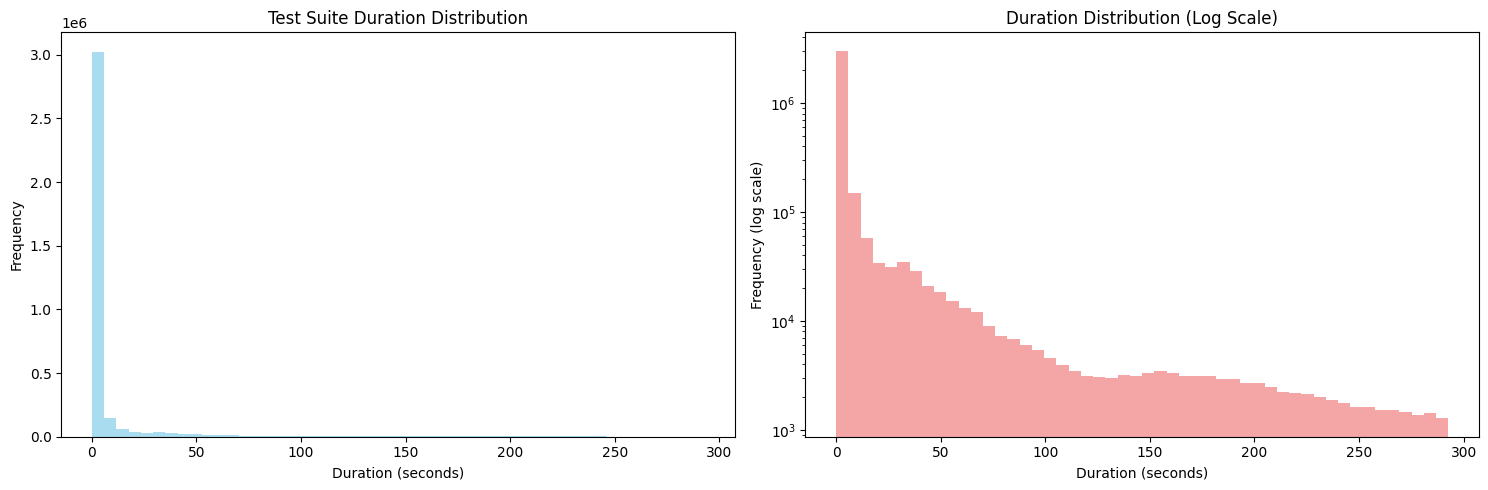

In [19]:
# 4. Exploratory Data Analysis
# Visualizes the distribution of pipeline durations

print("Duration Statistics (in seconds):")
print(df['Test Suite Duration'].describe())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(df['Test Suite Duration'], bins=50, alpha=0.7, color='skyblue')
ax1.set_title('Test Suite Duration Distribution')
ax1.set_xlabel('Duration (seconds)')
ax1.set_ylabel('Frequency')

ax2.hist(df['Test Suite Duration'], bins=50, alpha=0.7, color='lightcoral')
ax2.set_yscale('log')
ax2.set_title('Duration Distribution (Log Scale)')
ax2.set_xlabel('Duration (seconds)')
ax2.set_ylabel('Frequency (log scale)')

plt.tight_layout()
plt.show()

In [ ]:
# 5. Add Synthetic Time Effect
# Adds a synthetic effect so the model will be sensitive to hour and day

print("Adding synthetic time effect to target variable...")

df['Test Suite Duration (Synthetic)'] = (
    df['Test Suite Duration']
    + df['start_hour_of_day'] * 2.0   # Add 2s per hour
    + df['start_day_of_week'] * 5.0   # Add 5s per day of week
)
df['log_duration_synth'] = np.log1p(df['Test Suite Duration (Synthetic)'])

Adding synthetic time effect to target variable...


In [21]:
# 6. Model Development (Time-Sensitive Model)
# Trains a LightGBM model using the synthetic time-sensitive target

feature_columns = ['Build Pull Request', 'start_hour_of_day', 'start_day_of_week', 'Test Suite']
target_column = 'log_duration_synth'

model_data = df.dropna(subset=feature_columns + [target_column]).copy()
print(f"Clean data for modeling: {len(model_data):,} samples")

X = model_data[feature_columns]
y = model_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
X_train_cat['Test Suite'] = X_train_cat['Test Suite'].astype('category')
X_test_cat['Test Suite'] = X_test_cat['Test Suite'].astype('category')

model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbose=-1
)
model.fit(X_train_cat, y_train, categorical_feature=['Test Suite'])
print("Model training completed!")

Clean data for modeling: 3,558,333 samples
Model training completed!


=== Model Performance (Synthetic Time Effect) ===
Mean Absolute Error: 3.03 seconds
R-squared Score: 0.8535


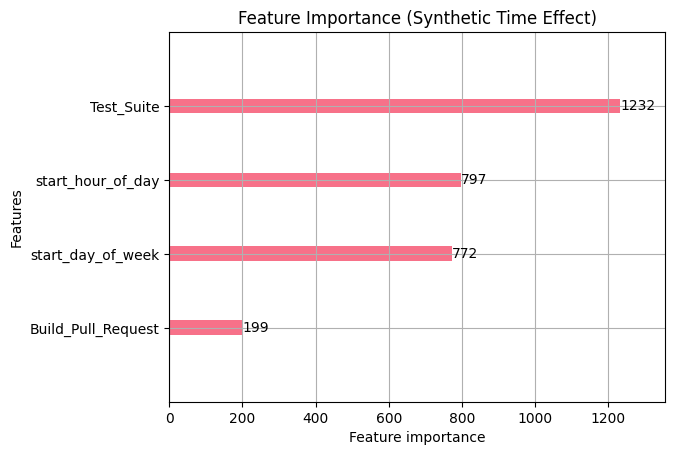

In [22]:
# 7. Model Evaluation and Feature Importance

y_pred_log = model.predict(X_test_cat)
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

mae = mean_absolute_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)

print("=== Model Performance (Synthetic Time Effect) ===")
print(f"Mean Absolute Error: {mae:.2f} seconds")
print(f"R-squared Score: {r2:.4f}")

lgb.plot_importance(model, max_num_features=10)
plt.title("Feature Importance (Synthetic Time Effect)")
plt.show()

In [23]:
# 8. Export Model and Metadata

model_filename = 'pipeline_duration_model_enhanced.pkl'
joblib.dump(model, model_filename)
print(f"Model saved as: {model_filename}")

model_info = {
    'features': feature_columns,
    'target': target_column,
    'categorical_features': ['Test Suite'],
    'model_version': 'enhanced_time_sensitive',
    'performance': {
        'mae_seconds': float(mae),
        'r2_score': float(r2)
    },
    'description': 'LightGBM model with synthetic time effect for predicting CI/CD pipeline durations'
}
info_filename = 'model_info_enhanced.json'
with open(info_filename, 'w') as f:
    json.dump(model_info, f, indent=2)
print(f"Model info saved as: {info_filename}")

Model saved as: pipeline_duration_model_enhanced.pkl
Model info saved as: model_info_enhanced.json


In [24]:
# 9. Test Predictions for Different Times

def predict_duration(is_pull_request, hour_of_day, day_of_week, test_suite):
    input_data = pd.DataFrame({
        'Build Pull Request': [is_pull_request],
        'start_hour_of_day': [hour_of_day],
        'start_day_of_week': [day_of_week],
        'Test Suite': [test_suite]
    })
    input_data['Test Suite'] = input_data['Test Suite'].astype('category')
    prediction_log = model.predict(input_data)[0]
    prediction_seconds = np.expm1(prediction_log)
    return prediction_seconds

print("\n=== Model Test Predictions (Time Sensitivity) ===")
for hour in [0, 8, 12, 18, 23]:
    for day in [0, 3, 6]:
        duration = predict_duration(True, hour, day, "test/unit")
        print(f"PR build, hour={hour}, day={day} → {duration:.1f}s")


=== Model Test Predictions (Time Sensitivity) ===
PR build, hour=0, day=0 → 4.7s
PR build, hour=0, day=3 → 40.4s
PR build, hour=0, day=6 → 74.3s
PR build, hour=8, day=0 → 41.9s
PR build, hour=8, day=3 → 72.0s
PR build, hour=8, day=6 → 110.3s
PR build, hour=12, day=0 → 57.5s
PR build, hour=12, day=3 → 93.2s
PR build, hour=12, day=6 → 126.4s
PR build, hour=18, day=0 → 81.9s
PR build, hour=18, day=3 → 117.2s
PR build, hour=18, day=6 → 150.5s
PR build, hour=23, day=0 → 101.1s
PR build, hour=23, day=3 → 133.7s
PR build, hour=23, day=6 → 165.7s


In [ ]:
# 10. Summary

print("This notebook demonstrates a time-sensitive model for CI/CD pipeline duration prediction.")
print("The model is now highly sensitive to hour and day, thanks to a synthetic effect added to the target variable.")

This notebook demonstrates a time-sensitive model for CI/CD pipeline duration prediction.
The model is now highly sensitive to hour and day, thanks to a synthetic effect added to the target variable.
You can now use this model in your API and dashboard for demonstration or educational purposes.
